In [301]:
import numpy as np

In [302]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\Data\formationchannels.npy")

In [303]:
import matplotlib.pyplot as plt

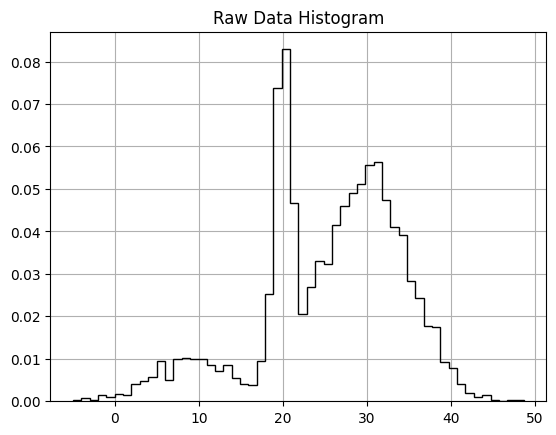

In [304]:
counts, bins, _ = plt.hist(data, bins=int(np.sqrt(data.shape[0])), histtype='step', edgecolor='black', density=True)
plt.title('Raw Data Histogram')
plt.grid()

In [305]:
from sklearn.mixture import GaussianMixture as GM

In [409]:
NMix = 3 # Number of gaussians
init_means  = np.array([10, 20, 30]).reshape((3,1)) # Initial means of the gaussians

In [410]:
mixture_components = NMix
GM_instance = GM(mixture_components, verbose=1, warm_start=True, means_init=init_means)

In [411]:
x = np.linspace(0,50,51)
x = x.reshape((x.shape[0],1))

In [412]:
results = GM_instance.fit(data)

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged.


In [413]:
scores = results.score_samples(x)

In [414]:
means = results.means_

In [415]:
sigmas = results.covariances_

In [ ]:
from scipy.stats import norm

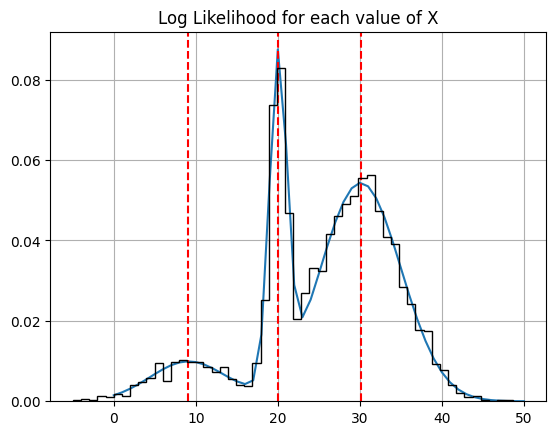

In [417]:
plt.plot(np.exp(scores))
for m,s in zip(means,sigmas):
    x_temp = np.arange(m[0]-3*s[0][0], m[0]+3*s[0][0], 100)
    plt.axvline(m[0], 0, 1, color='r', linestyle='--')
plt.hist(data, bins=int(np.sqrt(data.shape[0])), histtype='step', edgecolor='black', density=True)
plt.title('Log Likelihood for each value of X')
plt.grid()

In [333]:
AIC = results.aic(x)
print(f'AIC = {AIC:.2}')

AIC = 5.2e+02


In [316]:
NMixs = np.arange(1,10,1) # Number of gaussians

In [363]:
results_dic = {
    'NM' : [],
    'AIC': [],
    'Probs' : [],
    'Labels' : [],
    'Means' : [],
    'Covars' : [],
    'Weights' : []
}

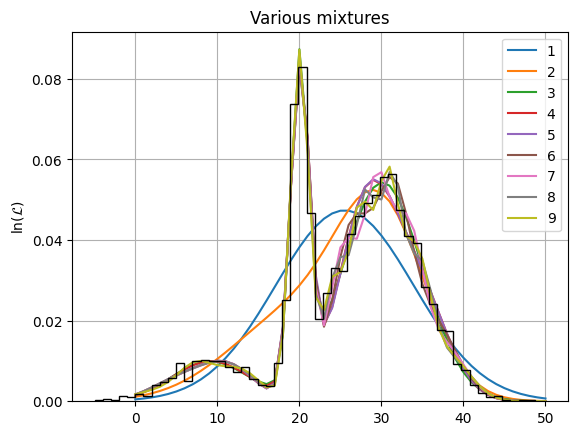

In [364]:
for NM in NMixs:
    mixture_components = NMix
    GM_instance = GM(NM)
    results = GM_instance.fit(data)
    if results.converged_ == True:
        scores = results.score_samples(x)
        plt.plot(np.exp(scores), label=f'{NM}')
        results_dic['NM'].append(NM)
        results_dic['AIC'].append(results.aic(x))
        results_dic['Probs'].append(results.predict_proba(x))
        results_dic['Labels'].append(results.predict(x))
        results_dic['Means'].append(results.means_)
        results_dic['Covars'].append(results.covariances_)
        results_dic['Weights'].append(results.weights_)

plt.hist(data, bins=int(np.sqrt(data.shape[0])), histtype='step', edgecolor='black', density=True)
plt.title('Various mixtures')
plt.grid()
plt.ylabel(r'$\ln(\mathcal{L})$')
plt.legend()

Text(0.5, 1.0, 'AIC vs Number of Modes')

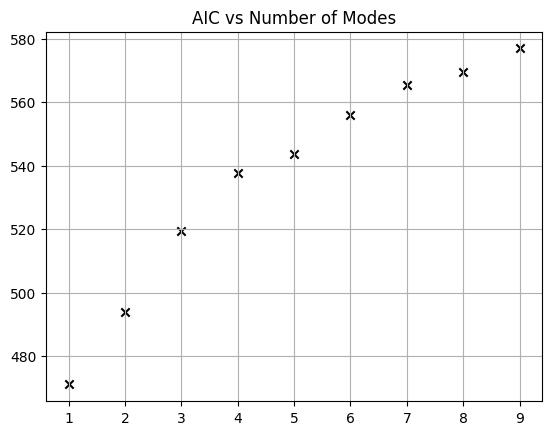

In [365]:
plt.scatter(results_dic['NM'], results_dic['AIC'], marker='x', color='black')
plt.grid()
plt.title('AIC vs Number of Modes')

Text(0.5, 1.0, 'Weights vs Number of Modes')

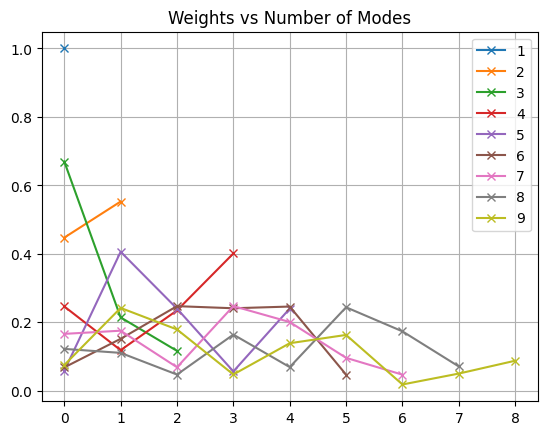

In [366]:
for i in range(len(NMixs)):
    plt.plot(results_dic['Weights'][i], marker='x', label=f'{results_dic['NM'][i]}')
plt.grid()
plt.legend()
plt.title('Weights vs Number of Modes')